# POTENTIAL AREA based on FAVORITE PLACE

In [2]:
import arcpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal as ps
import mapclassify as mc
import os
import math
from tabulate import tabulate
workspace = r"C:\Users\beben\Documents\Bootcamp - Statistics - Pacmann\Project\3_SQL dan Wrangling\Geodatabase - Arcgis Pro\data_raw_shp"
arcpy.env.workspace = workspace

## Overview
Pengolahan menggunakan beberapa library dengan dominan penggunaan yaitu ArcPY dan Geopandas.

> ArcPy : Merupakan library ArcGIS yang menyediakan fungsi dan tools terkait analisa spatial, mapping, dan processing data data terkait geospatial. Sebelum ingin menggunakan library ArcPy, user harus sudah menginstall ArcMap atau ArcGIS Pro.

> Geopandas : Merupakan library *open source*, yang mana user dapat melakukan analisa terkait geospatial. Pada riset ini Geopandas lebih digunakan untuk visualisasi

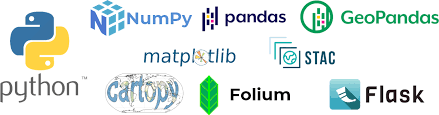

Sebelum melakukan pengolahan data, diperlukan beberapa data seperti daerah kunjungan visitor tertinggi yang telah di agregasi pada polygon hexagon menggunakan ArcGIS. Data Demography juga di agregasi pada polygon hexagon menggunakan beberapa function st_geometry pada PostgreeSQL.

Data yang digunakan :
1. Visitor in POI = Data ini merupakan jumlah kunjungan pada sebuah lokasi/POI yang berhasil tercapture oleh google maps. Data yang diambil yaitu terkait dengan (Perkantoran, Shooping, Restoran, Hiburan).

![2023-07-09 00_01_03-Monumen Nasional - Google Maps — Mozilla Firefox.png](<attachment:2023-07-09 00_01_03-Monumen Nasional - Google Maps — Mozilla Firefox.png>)

2. Data Demography yang di mempresentasikan SES (Sosio Economic Status), data ini umumnya bisa didapatkan pada BPS.
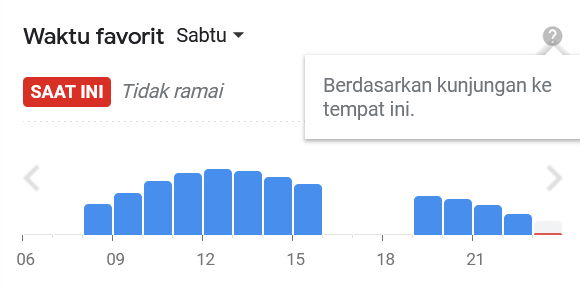

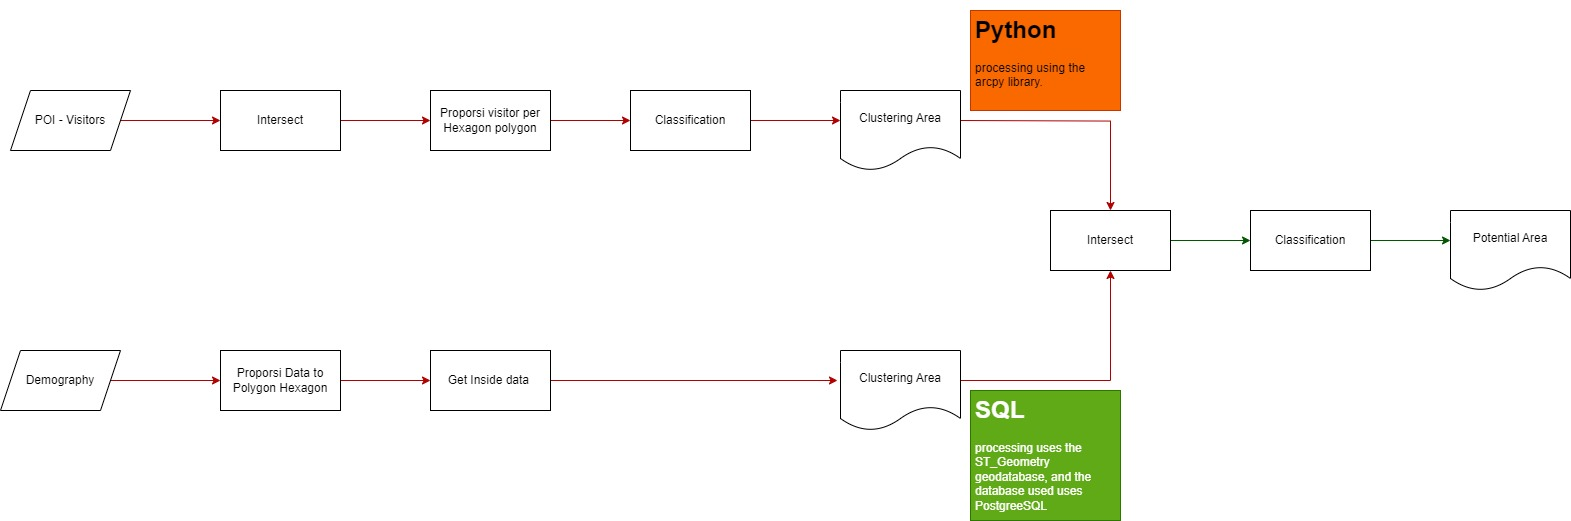

## #1 Checking Data

In [15]:
list_data = arcpy.ListFeatureClasses() #Mengecek data yang terdapat pada folder
print(list_data)

## Membuat parameter data shapefile yang akan digunakan 
get_fav_place = os.path.join(workspace, "favorite_place.shp")
get_demography = os.path.join(workspace, "demography.shp")

['demography.shp', 'favorite_place.shp', 'spatial_join_fp_dm.shp']


In [147]:
#data1_fp = arcpy.ListFeatureclasses_dm(data1)
data1_fp_field = arcpy.ListFields(get_fav_place)
data2_dm_field = arcpy.ListFields(get_demography)

print("field from favorite_place.shp")
for x in data1_fp_field :
    print(x.name)
print("field from demography.shp")
for y in data2_dm_field :
    print(y.name)
    


field from favorite_place.shp
FID
Shape
left
top
right
bottom
Total_Popu
kelas
field from demography.shp
FID
Shape
objectid
left_
top
right_
bottom
tk_negeri
tk_swasta
sd_negeri
sd_swasta
smp_negeri
smp_swasta
sma_negeri
sma_swasta
jml_pendud
jml_kk
wanita
pria
tidak_beke
asn_pns
tenaga_pen
wiraswasta
petani
nelayan
pelajar
tenaga_med
pensiunan
pekerjaan_
pop_ses_a
pop_ses_b
pop_ses_c
pop_ses_d
pop_ses_e
pop_domina
hh_ses_a
hh_ses_b
hh_ses_c
hh_ses_d
hh_ses_e
hh_dominan
jml_mobil
jml_bus
jml_truk
jml_motor
shape_Leng
shape_Area
kelas_dm


In [138]:
list_data_processing = arcpy.ListFeatureClasses(get_fav_place)
print(list_data_processing)

['favorite_place.shp']


### Checking Attribute Table (Data Favorite Place)

In [139]:
#get_fav_place1 = r"C:\Users\beben\Documents\Bootcamp - Statistics - Pacmann\Project\3_SQL dan Wrangling\Geodatabase - Arcgis Pro\data_raw_shp\favorite_place.shp"

fields_fp = [f.name for f in arcpy.ListFields(get_fav_place)]

# Cetak nama field atau header
print(", ".join(fields_fp))

with arcpy.da.SearchCursor(get_fav_place, fields_fp) as cursor :
    for row in cursor :
        print(", ".join(str(val) for val in row))

FID, Shape, left, top, right, bottom, Total_Popu, kelas
0, (677286.5408230275, 9203925.5909), 676593.7205, 9204525.5909, 677979.361146, 9203325.5909, 0, 0
1, (677286.5408230275, 9202725.5909), 676593.7205, 9203325.5909, 677979.361146, 9202125.5909, 0, 0
2, (677286.5408230275, 9201525.5909), 676593.7205, 9202125.5909, 677979.361146, 9200925.5909, 3233, 1
3, (677286.5408230275, 9200325.5909), 676593.7205, 9200925.5909, 677979.361146, 9199725.5909, 22, 1
4, (677286.5408230275, 9199125.5909), 676593.7205, 9199725.5909, 677979.361146, 9198525.5909, 0, 0
5, (677286.5408230275, 9197925.5909), 676593.7205, 9198525.5909, 677979.361146, 9197325.5909, 0, 0
6, (678325.7713075689, 9203325.5909), 677632.950985, 9203925.5909, 679018.591631, 9202725.5909, 0, 0
7, (678325.7713075689, 9202125.5909), 677632.950985, 9202725.5909, 679018.591631, 9201525.5909, 0, 0
8, (678325.7713075689, 9200925.5909), 677632.950985, 9201525.5909, 679018.591631, 9200325.5909, 6, 1
9, (678325.7713075689, 9199725.5909), 67763

## Favorite Place Data Processing

### Processing of frequency distribution to get range of intervals and classification 

In [16]:
#Mengecek nilai terkecil dan terbesar serta n-data

nilai_fields = ["Total_Popu"]

min_value = None
max_value = None

with arcpy.da.SearchCursor(get_fav_place,nilai_fields) as cursor :
    for row in cursor :
        value = row[0]
        if min_value is None or value < min_value:
            min_value = value
        if max_value is None or value > max_value:
            max_value = value
            
print("Jumlah Tracking Visitor Terendah adalah :", min_value)
print("Jumlah Tracking Visitor Tertinggi adalah :", max_value)

count_row = 0

with arcpy.da.SearchCursor(get_fav_place,nilai_fields) as cursor :
    for row in cursor :
        if row[0] is not None :
            count_row+=1
            
print("Banyak data :",count_row)
 

Jumlah Tracking Visitor Terendah adalah : 0
Jumlah Tracking Visitor Tertinggi adalah : 151210
Banyak data : 309


In [113]:
# Distribusi Frekuensi 

## Banyak Kelas
param1 = 1
param2 = 3.3
param3 = math.log(count_row)
#print(param3)

processing_class = param1+(param2*param3)
print("Banyak kelas yaitu :", round(processing_class,2))

## Panjang Kelas
count_p_kelas = (max_value-min_value)/processing_class
print("Interval klasifikasi yaitu :",count_p_kelas)


Banyak kelas yaitu : 19.92
Interval klasifikasi yaitu : 7590.85346461695


In [17]:
# Melakukan klasifikasi dan range data

min_value_fp = min_value
max_value_fp = max_value
interval_fp = 7591

# Menghitung jumlah kelas
num_classes_dm_fp = (max_value_fp - min_value_fp) // interval_fp + 1

# Membuat list range kelas
class_ranges_fp = []
for i in range(num_classes_dm_fp):
    start_range = min_value_fp + (interval_fp * i)
    end_range = min_value_fp + (interval_fp * (i + 1)) - 1
    class_ranges_fp.append((start_range, end_range))


# Menampilkan range kelas dalam tabel
table = []
for i, (start, end) in enumerate(class_ranges_fp, start=1):
    table.append([f"{start}-{end}", i])

headers = ["Range", "Kelas"]
print(tabulate(table, headers, tablefmt="grid"))

+---------------+---------+
| Range         |   Kelas |
+===============+=========+
| 0-7590        |       1 |
+---------------+---------+
| 7591-15181    |       2 |
+---------------+---------+
| 15182-22772   |       3 |
+---------------+---------+
| 22773-30363   |       4 |
+---------------+---------+
| 30364-37954   |       5 |
+---------------+---------+
| 37955-45545   |       6 |
+---------------+---------+
| 45546-53136   |       7 |
+---------------+---------+
| 53137-60727   |       8 |
+---------------+---------+
| 60728-68318   |       9 |
+---------------+---------+
| 68319-75909   |      10 |
+---------------+---------+
| 75910-83500   |      11 |
+---------------+---------+
| 83501-91091   |      12 |
+---------------+---------+
| 91092-98682   |      13 |
+---------------+---------+
| 98683-106273  |      14 |
+---------------+---------+
| 106274-113864 |      15 |
+---------------+---------+
| 113865-121455 |      16 |
+---------------+---------+
| 121456-129046 |   

## Spatial data processing and visualization - Favorite Place

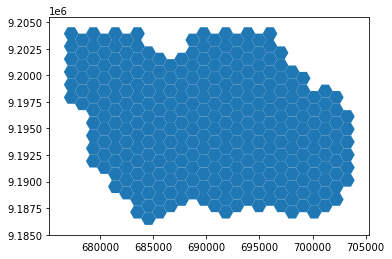

In [84]:
# Specify the path to the shapefile
shp_path = r"C:\Users\beben\Documents\Bootcamp - Statistics - Pacmann\Project\3_SQL dan Wrangling\Geodatabase - Arcgis Pro\data_raw_shp\favorite_place.shp"

# Read the shapefile using GeoPandas
gdf = gpd.read_file(shp_path)

# Plot the shapefile
gdf.plot()

# Show the plot
plt.show()

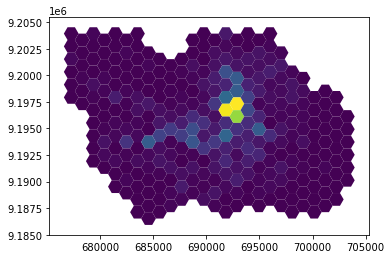

In [92]:
# Plot the shapefile
gdf.plot(column='Total_Popu')

# Show the plot
plt.show()


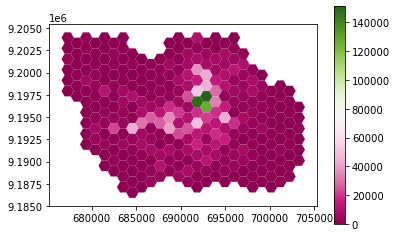

In [104]:
# Klasifikasi berdasarkan field 'Total_Popu'
classes_fp = max_value
gdf['Total_Popu_Class'] = pd.cut(gdf['Total_Popu'], bins=classes_fp, labels=False, precision=3)

# Plot shapefile berdasarkan kelas 'Total_Popu_Class'
gdf.plot(column='Total_Popu_Class', cmap='PiYG', legend=True)

# Tampilkan plot
plt.show()

## Create a new field and classify by range - Favorite Place

In [ ]:
# Field names
total_popu_field = "total_popu"
kelas_field = "kelas"

# Create new field
arcpy.AddField_management(get_fav_place, kelas_field, "SHORT")

# Update field values based on Total_Popu intervals
with arcpy.da.UpdateCursor(get_fav_place, [total_popu_field, kelas_field]) as cursor:
    for row in cursor:
        total_popu = row[0]
        kelas = (total_popu - 1) // 7591 + 1
        row[1] = kelas
        cursor.updateRow(row)

print("Field 'kelas' has been created and values have been classified.")

### Result - Favorite place classification map

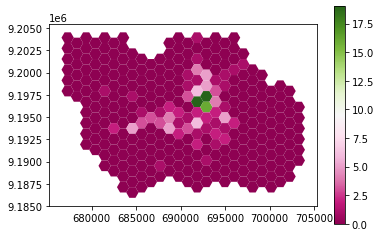

In [124]:
# Klasifikasi berdasarkan field 'Total_Popu'
classes_fp = 20
gdf['Total_Kelas_Favorite_Place'] = pd.cut(gdf['kelas'], bins=classes_fp, labels=False, precision=3)

# Plot shapefile berdasarkan kelas 'Total_Popu_Class'
gdf.plot(column='kelas', cmap='PiYG', legend=True)

# Tampilkan plot
plt.show()

## Demography Data Processing

### Processing of frequency distribution to get range of intervals and classification 

In [115]:
fields_dm = [f.name for f in arcpy.ListFields(get_demography)]

# Cetak nama field atau header
print(", ".join(fields_dm))

with arcpy.da.SearchCursor(get_demography, fields_dm) as cursor :
    for row in cursor :
        print(", ".join(str(val) for val in row))

FID, Shape, objectid, left_, top, right_, bottom, tk_negeri, tk_swasta, sd_negeri, sd_swasta, smp_negeri, smp_swasta, sma_negeri, sma_swasta, jml_pendud, jml_kk, wanita, pria, tidak_beke, asn_pns, tenaga_pen, wiraswasta, petani, nelayan, pelajar, tenaga_med, pensiunan, pekerjaan_, pop_ses_a, pop_ses_b, pop_ses_c, pop_ses_d, pop_ses_e, pop_domina, hh_ses_a, hh_ses_b, hh_ses_c, hh_ses_d, hh_ses_e, hh_dominan, jml_mobil, jml_bus, jml_truk, jml_motor, shape_Leng, shape_Area
0, (112.76582548293669, -7.269073696635008), 1, 694260.638737, 9196725.5909, 695646.279383, 9195525.5909, 0, 8, 2, 1, 0, 2, 0, 1, 24270, 8003, 12276, 11995, 5150, 877, 281, 8684, 8, 0, 4772, 184, 270, 4041, 3564, 10617, 10069, 20, 0, 10617, 1175, 3501, 3320, 7, 0, 3501, 1115, 21, 434, 11454, 0.0376127026394, 0.000102098208006
1, (112.68099297838407, -7.231419491003821), 2, 684907.564376, 9200925.5909, 686293.205022, 9199725.5909, 0, 0, 0, 0, 0, 0, 0, 0, 1023, 311, 502, 522, 358, 8, 10, 311, 2, 16, 107, 1, 1, 208, 150, 4

In [19]:
nilai_fields_dm = ["pop_ses_a"]

min_value_dm = None
max_value_dm = None

with arcpy.da.SearchCursor(get_demography,nilai_fields_dm) as cursor :
    for row in cursor :
        value = row[0]
        if min_value_dm is None or value < min_value_dm:
            min_value_dm = value
        if max_value_dm is None or value > max_value_dm:
            max_value_dm = value
            
print("Jumlah Populasi SES A Terendah adalah :", min_value_dm)
print("Jumlah Populasi SES A Tertinggi adalah :", max_value_dm)

count_row_dm = 0

with arcpy.da.SearchCursor(get_demography,nilai_fields_dm) as cursor :
    for row in cursor :
        if row[0] is not None :
            count_row_dm+=1
            
print("Banyak data :",count_row_dm)
 

Jumlah Populasi SES A Terendah adalah : 0
Jumlah Populasi SES A Tertinggi adalah : 8312
Banyak data : 309


In [20]:
# Distribusi Frekuensi 

## Banyak Kelas
param1_dm = 1
param2_dm = 3.3
param3_dm = math.log(count_row_dm)
#print(param3)

processing_class_dm = param1_dm+(param2_dm*param3_dm)
print("Banyak kelas yaitu :", round(processing_class_dm,2))

## Panjang Kelas
count_p_kelas_dm = (max_value_dm-min_value_dm)/processing_class_dm
print("Interval klasifikasi yaitu :",count_p_kelas_dm)


Banyak kelas yaitu : 19.92
Interval klasifikasi yaitu : 417.2685271998948


In [95]:
min_value_dm_ = min_value_dm
max_value_dm_ = max_value_dm
interval_dm = 417
# Menghitung jumlah kelas
num_classes_dm = (max_value_dm_ - min_value_dm_) // interval_dm + 1
print(num_classes_dm)
# Membuat list range kelas
class_ranges_dm = []
for i in range(num_classes_dm):
    start_range = min_value_dm_ + (interval_dm * i)
    end_range = min_value_dm_ + (interval_dm * (i + 1)) - 1
    class_ranges_dm.append((start_range, end_range))


# Menampilkan range kelas dalam tabel
table = []
for i, (start, end) in enumerate(class_ranges_dm, start=1):
    table.append([f"{start}-{end}", i])

headers = ["Range", "Kelas"]
print(tabulate(table, headers, tablefmt="grid"))

20
+-----------+---------+
| Range     |   Kelas |
+===========+=========+
| 0-416     |       1 |
+-----------+---------+
| 417-833   |       2 |
+-----------+---------+
| 834-1250  |       3 |
+-----------+---------+
| 1251-1667 |       4 |
+-----------+---------+
| 1668-2084 |       5 |
+-----------+---------+
| 2085-2501 |       6 |
+-----------+---------+
| 2502-2918 |       7 |
+-----------+---------+
| 2919-3335 |       8 |
+-----------+---------+
| 3336-3752 |       9 |
+-----------+---------+
| 3753-4169 |      10 |
+-----------+---------+
| 4170-4586 |      11 |
+-----------+---------+
| 4587-5003 |      12 |
+-----------+---------+
| 5004-5420 |      13 |
+-----------+---------+
| 5421-5837 |      14 |
+-----------+---------+
| 5838-6254 |      15 |
+-----------+---------+
| 6255-6671 |      16 |
+-----------+---------+
| 6672-7088 |      17 |
+-----------+---------+
| 7089-7505 |      18 |
+-----------+---------+
| 7506-7922 |      19 |
+-----------+---------+
| 7923-8339 |

## Spatial data processing and visualization - Demography Data

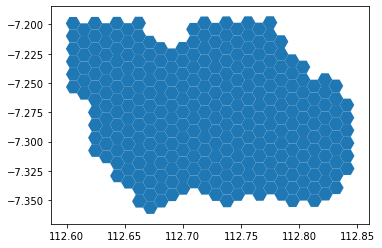

In [127]:
# Specify the path to the shapefile
shp_path_dm = r"C:\Users\beben\Documents\Bootcamp - Statistics - Pacmann\Project\3_SQL dan Wrangling\Geodatabase - Arcgis Pro\data_raw_shp\demography.shp"

# Read the shapefile using GeoPandas
gdf_dm = gpd.read_file(shp_path_dm)

# Plot the shapefile
gdf_dm.plot()

# Show the plot
plt.show()

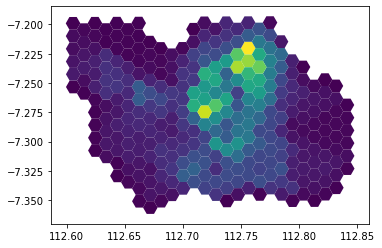

In [128]:
# Plot the shapefile
gdf_dm.plot(column='pop_ses_a')

# Show the plot
plt.show()


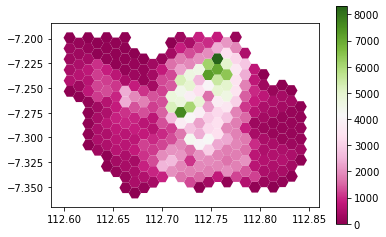

In [129]:
# Klasifikasi berdasarkan field 'Total_Popu'
classes_dm = max_value_dm
gdf_dm['pop_ses_a_Class'] = pd.cut(gdf_dm['pop_ses_a'], bins=classes_dm, labels=False, precision=3)

# Plot shapefile berdasarkan kelas 'Total_Popu_Class'
gdf_dm.plot(column='pop_ses_a_Class', cmap='PiYG', legend=True)

# Tampilkan plot
plt.show()

## Create a new field and classify by range - Demography Data

In [ ]:
# Field names
total_popu_field_dm = "pop_ses_a"
kelas_field_dm = "kelas_dm"

# Create new field
arcpy.AddField_management(get_demography, kelas_field_dm, "SHORT")

# Update field values based on Total_Popu intervals
with arcpy.da.UpdateCursor(get_demography, [total_popu_field_dm, kelas_field_dm]) as cursor:
    for row in cursor:
        total_sesA = row[0]
        kelas_sesA = (total_sesA - 1) // 417 + 1
        row[1] = kelas_sesA
        cursor.updateRow(row)

print("Field 'kelas' has been created and values have been classified.")

### Result - Demography data classification map

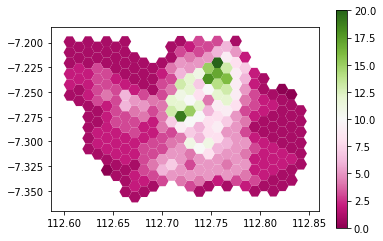

In [131]:
# Klasifikasi berdasarkan field 'Total_Popu'
classes_dm = 20
gdf_dm['Total_Kelas_Demography'] = pd.cut(gdf_dm['kelas_dm'], bins=classes_dm, labels=False, precision=3)

# Plot shapefile berdasarkan kelas 'Total_Popu_Class'
gdf_dm.plot(column='kelas_dm', cmap='PiYG', legend=True)

# Tampilkan plot
plt.show()

## Spatial Join (Favorite Place - Demography Data)
Pengolahan ini menggunakan library Arcpy(arcpy.SpatialJoin_analysis), hasil dari pengolahan akan menggabungkan 2 data langkah selanjutnya yaitu mencari klasifikasi berdasarkan nilai kelas yang telah diolah (Favorite Place dan Demography). Dengan perhitungan sederhana :

> kelas_value_favorite_place + kelas_value_demography // (2)

Hasil dari perhitungan akan memunculkan wilayah wilayah yang bisa menjadi lokasi potential dalam ekspansi bisnis

### Spatial Join (ArcPy)

In [148]:
# Set output feature class path
output_fc_sj = os.path.join(workspace, "spatial_join_fp_dm.shp")

# Perform spatial join
arcpy.SpatialJoin_analysis(get_fav_place, get_demography, output_fc_sj)

# Print message when spatial join is completed
print("Spatial join completed. Output saved to:", output_fc_sj)

Spatial join completed. Output saved to: C:\Users\beben\Documents\Bootcamp - Statistics - Pacmann\Project\3_SQL dan Wrangling\Geodatabase - Arcgis Pro\data_raw_shp\spatial_join_fp_dm.shp


### Calculate the classification of potential areas

In [6]:
get_result_sj = os.path.join(workspace, "spatial_join_fp_dm.shp")

# Field names
kelas_fp = "kelas"
kelas_dm = "kelas_dm"
field_potential = "potential"

# Create new field
arcpy.AddField_management(get_result_sj, field_potential, "SHORT")

# Update field values based on Total_Popu intervals
with arcpy.da.UpdateCursor(get_result_sj, [kelas_fp, kelas_dm, field_potential]) as cursor:
    for row in cursor:
        kelas_fp_value = row[0]
        kelas_dm_value = row[1]
        potential_area = (kelas_fp_value + kelas_dm_value) // 2
        row[2] = potential_area
        cursor.updateRow(row)

print("Field Potential Area has been created and values have been classified.")


Field Potential Area has been created and values have been classified.


### Result Potential Area

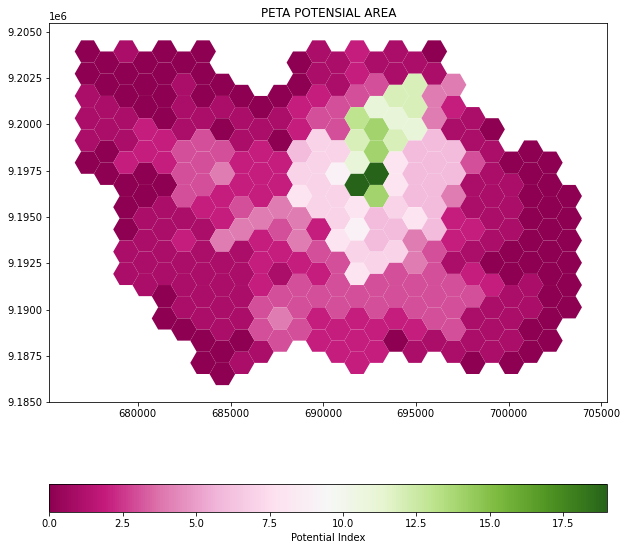

In [14]:
# Specify the path to the shapefile
shp_path_pa = r"C:\Users\beben\Documents\Bootcamp - Statistics - Pacmann\Project\3_SQL dan Wrangling\Geodatabase - Arcgis Pro\data_raw_shp\spatial_join_fp_dm.shp"

# Read the shapefile using GeoPandas
gdf_pa = gpd.read_file(shp_path_pa)

# Klasifikasi berdasarkan field 'Total_Popu'
classes_pa = 20
gdf_pa['Potential_Area_Class'] = pd.cut(gdf_pa['potential'], bins=classes_pa, labels=False, precision=3)

# Plot shapefile berdasarkan kelas 'Total_Popu_Class'
fig, ax = plt.subplots(figsize=(10, 10))
gdf_pa.plot(ax=ax, 
            column='Potential_Area_Class', 
            cmap='PiYG', 
            legend=True,
            legend_kwds={"label": "Potential Index", "orientation": "horizontal"}
            )
ax.set_title("PETA POTENSIAL AREA")

# Tampilkan plot
plt.show()